To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Llama 3.2 11B to assist medical professionals in analyzing xrays, CT scans & ultrasounds.**

In [ ]:

!pip uninstall unsloth -y
!pip install unsloth
# Also get the latest nightly Unsloth!


In [ ]:
!pip install torchvision torch -U

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.11.9: Fast Mllama vision patching. Transformers = 4.46.3.
   \\   /|    GPU: NVIDIA L40S. Max memory: 44.527 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.9. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [2]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Prep
We'll be using the ROCO radiography dataset. We sampled 0.33% to make the dataset faster to load. The goal is to make the model describe what it sees in each


You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).


In [3]:
from datasets import load_dataset
dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1", split = "train")
dataset = dataset.select(range(500))


Let's take an overview look at the dataset. We shall see what the first image is, and what caption it had.

In [4]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2481x3508>,
 'id': '0',
 'parsed_data': '{"xml": "", "json": "{\'header\': {\'invoice_no\': \'40378170\', \'invoice_date\': \'10/15/2012\', \'seller\': \'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228\', \'client\': \'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601\', \'seller_tax_id\': \'958-74-3511\', \'client_tax_id\': \'998-87-7723\', \'iban\': \'GB77WRBQ31965128414006\'}, \'items\': [{\'item_desc\': \\"Leed\'s Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter\\", \'item_qty\': \'1,00\', \'item_net_price\': \'7,50\', \'item_net_worth\': \'7,50\', \'item_vat\': \'10%\', \'item_gross_worth\': \'8,25\'}], \'summary\': {\'total_net_worth\': \'$7,50\', \'total_vat\': \'$0,75\', \'total_gross_worth\': \'$8,25\'}}", "kie": ""}',
 'raw_data': '{"ocr_words": "[\'Invoice no: 40378170\', \'Date of issue:\', \'10/15/2012\', \'Seller:\', \'Client:\', \'Patel, Tho

In [5]:
dataset[0]["raw_data"]

'{"ocr_words": "[\'Invoice no: 40378170\', \'Date of issue:\', \'10/15/2012\', \'Seller:\', \'Client:\', \'Patel, Thompson and Montgomery\', \'Jackson, Odonnell and Jackson.\', \'356 Kyle Vista\', \'267 John Track Suite 841\', \'New James, MA 46228\', \'Jenniferville, PA 98601\', \'Tax Id: 958-74-3511\', \'Tax Id: 998-87-7723\', \'IBAN: GB77WRBQ31965128414006\', \'ITEMS\', \'UM\', \'No.\', \'Description\', \'Qty\', \'Net price\', \'Net worth\', \'VAT [%]\', \'Gross\', \'worth\', \\" Leed\'s Wine Companion Bottle\\", \'1,00\', \'each\', \'7,50\', \'7,50\', \'10%\', \'8,25\', \'Corkscrew Opener Gift Box Set\', \'with Foil Cutter\', \'SUMMARY\', \'VAT [%]\', \'VAT\', \'Net worth\', \'Gross worth\', \'7,50\', \'10%\', \'0,75\', \'8,25\', \'Total\', \'$7,50\', \'$ 0,75\', \'$8,25\']", "ocr_boxes": "[[[[196.0, 110.0], [801.0, 110.0], [801.0, 161.0], [196.0, 161.0]], (\'Invoice no: 40378170\', 0.9985853433609009)], [[[196.0, 212.0], [517.0, 212.0], [517.0, 259.0], [196.0, 259.0]], (\'Date of 

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```
We can also add an specify you are an expert medical radiographer.

In [6]:
instruction = "You are an OCR assistant. Extract the text from this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["parsed_data"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [7]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

We look at how the conversations are structured for the first example:

In [8]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an OCR assistant. Extract the text from this image.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2481x3508>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{"xml": "", "json": "{\'header\': {\'invoice_no\': \'40378170\', \'invoice_date\': \'10/15/2012\', \'seller\': \'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228\', \'client\': \'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601\', \'seller_tax_id\': \'958-74-3511\', \'client_tax_id\': \'998-87-7723\', \'iban\': \'GB77WRBQ31965128414006\'}, \'items\': [{\'item_desc\': \\"Leed\'s Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter\\", \'item_qty\': \'1,00\', \'item_net_price\': \'7,50\', \'item_net_worth\': \'7,50\', \'item_vat\': \'10%\', \'item_gross_worth\': \'8,25\'}], \'summary\': {\'total_net_worth\': \'$7,50

Let's first see before we do any finetuning what the model outputs for the first example!

In [9]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction =  "You are an OCR assistant. Extract the test from this image."


messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The text in the image reads:

Invoice no: 40378170
Date of issue: 10/15/2012
Seller:
Patel, Thompson and Montgomery
356 Kyle Vista
New James, MA 46228
Tax Id: 958-74-3511
IBAN: GB77WRBQ31965128414006
Client:
Jackson, Odonnell and Jackson
267 John Track Suite 841
Jenniferville, PA 98601
Tax Id: 998-87-7723
Items:
1.  Description:Leed's Wine Companion Bottle Corkscrew Op


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [10]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 30,
        num_train_epochs=1,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [11]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L40S. Max memory = 44.527 GB.
8.473 GB of memory reserved.


In [12]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 500 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 62
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.426700
2,0.723100
3,0.559200
4,0.544800
5,0.397600
6,0.452100
7,0.281200
8,0.228000
9,0.179000
10,0.304100


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.75 GiB. GPU 0 has a total capacity of 44.53 GiB of which 5.72 GiB is free. Process 110373 has 38.80 GiB memory in use. Of the allocated memory 38.14 GiB is allocated by PyTorch, and 151.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

NameError: name 'trainer_stats' is not defined

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [22]:
dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1", split = "test")


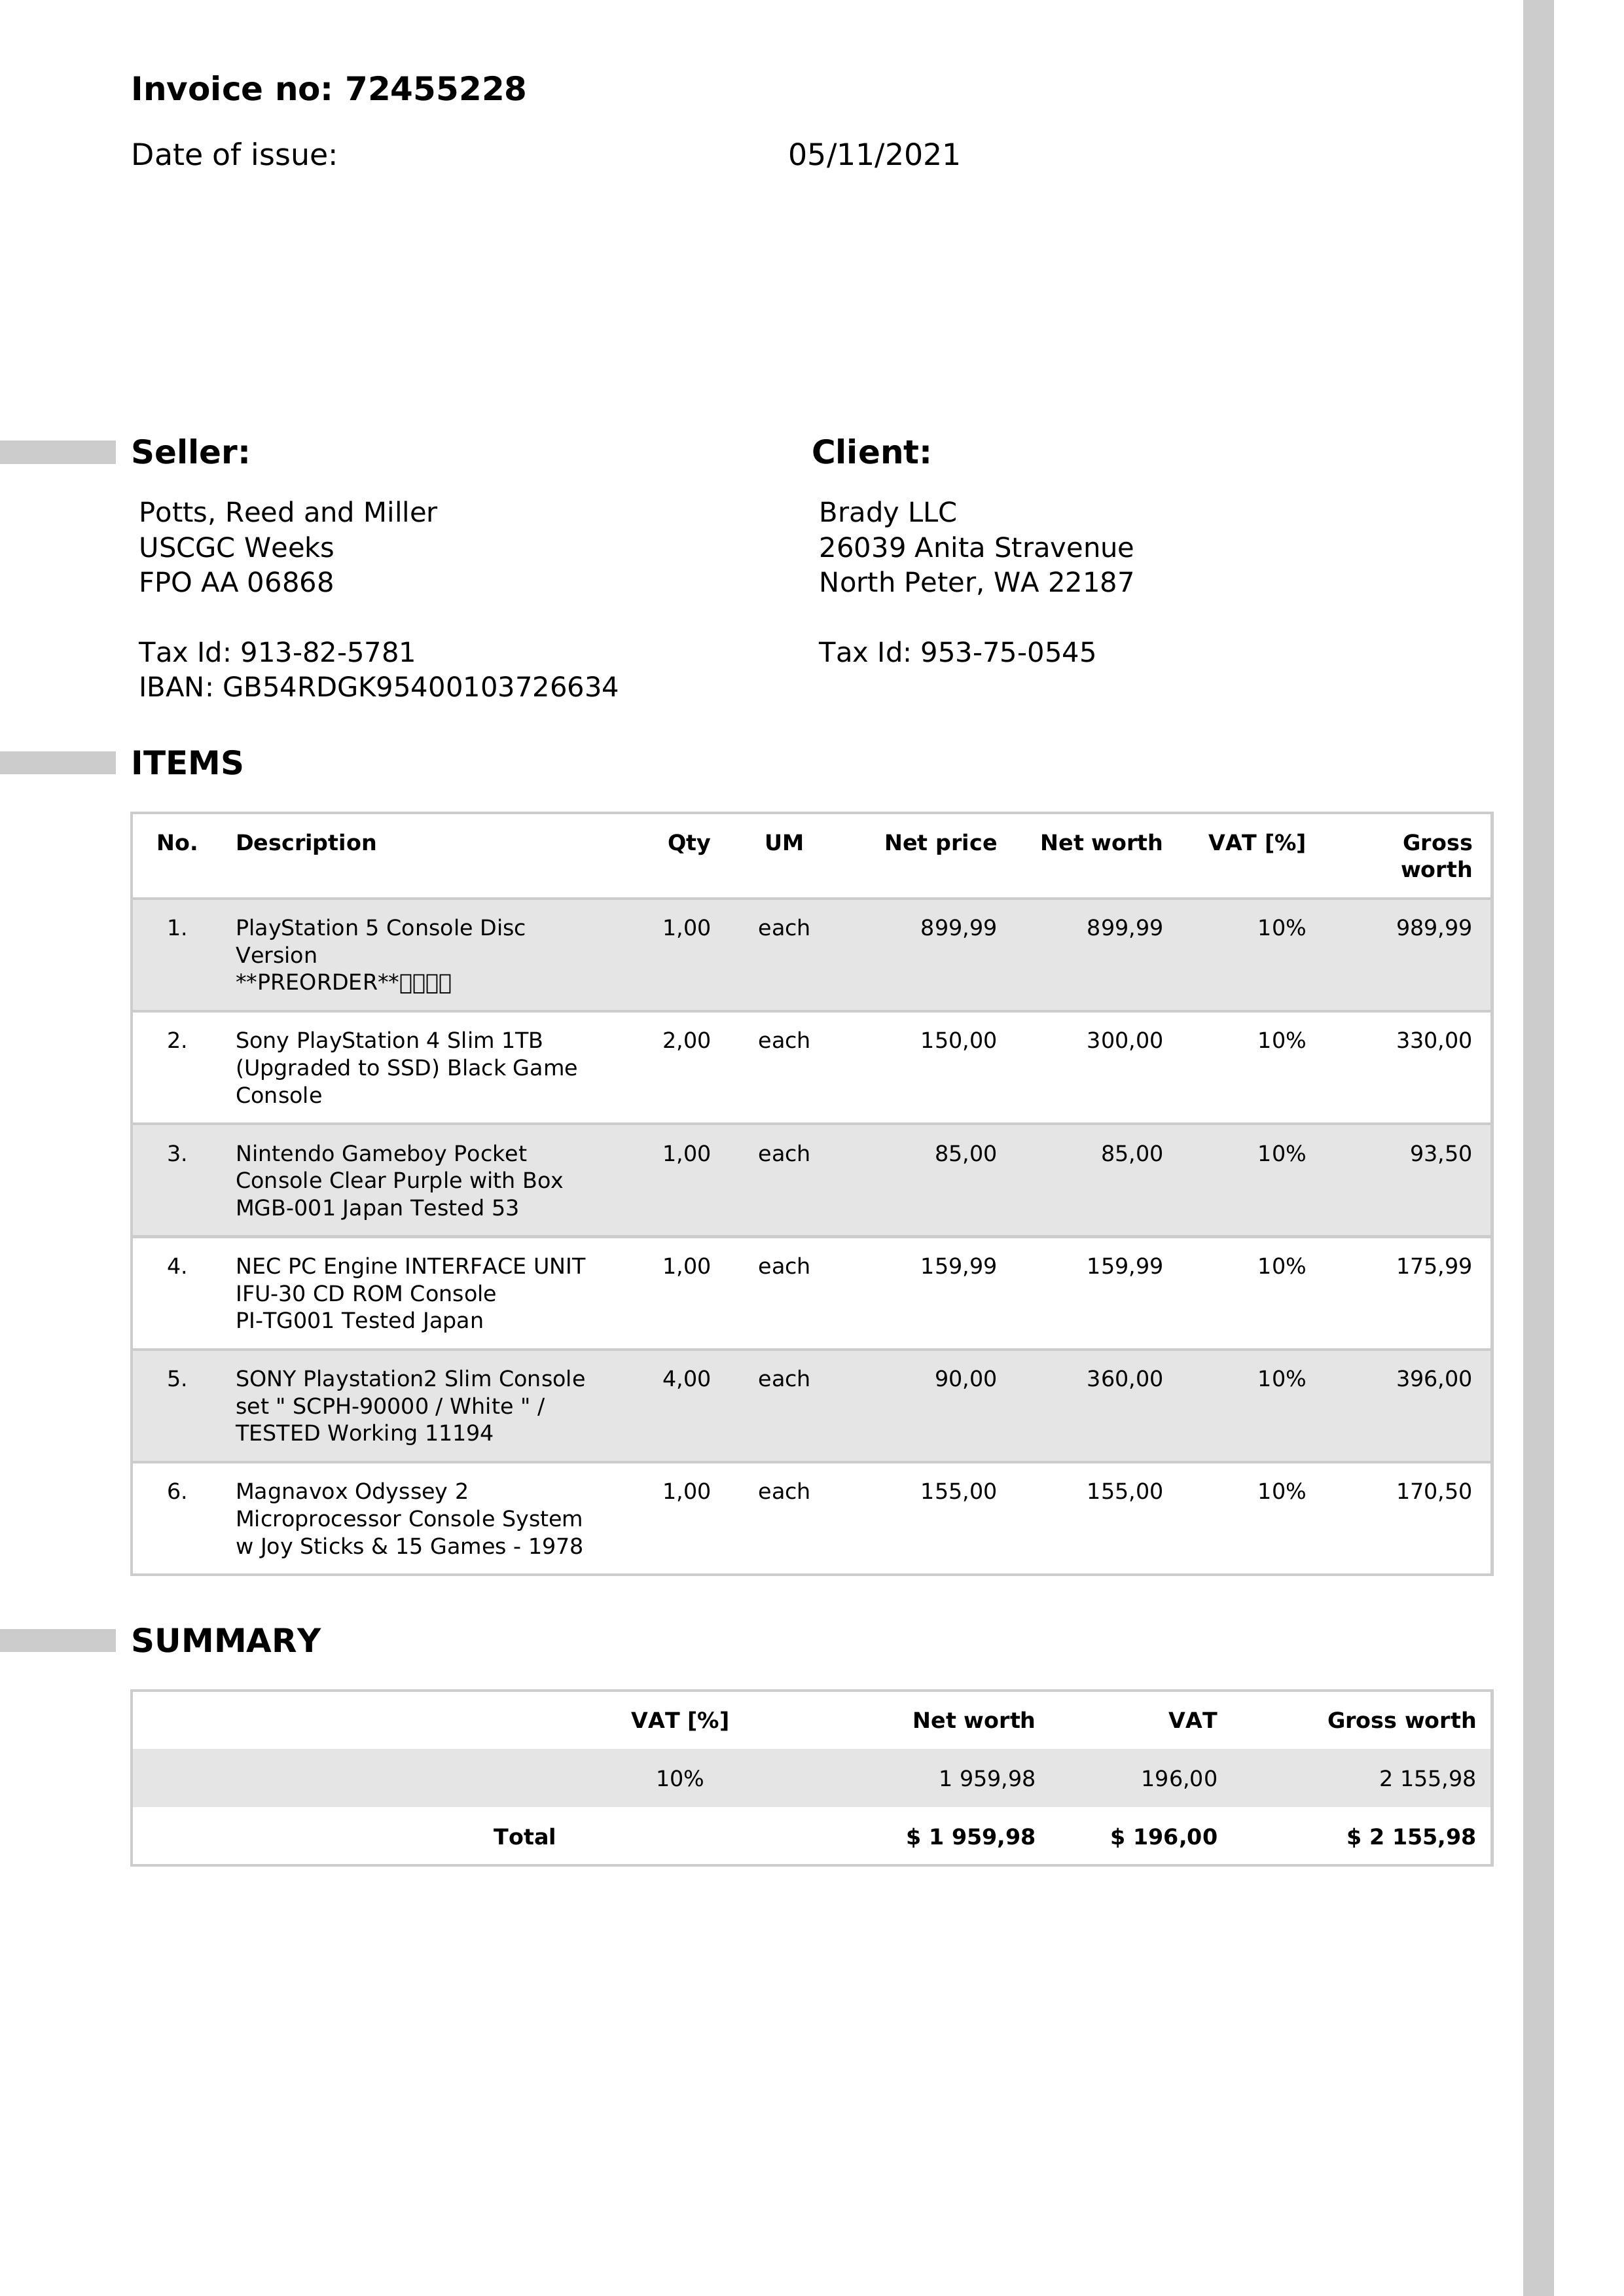

In [26]:
dataset[10]["image"]

In [23]:
len(dataset)

125

In [27]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[10]["image"]
instruction = "You are an OCR assistant. Extract the test from this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1000,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

{"xml": "", "json": "{'header': {'invoice_no': '72455228', 'invoice_date': '05/11/2021', seller': 'Potts, Reed and Miller USCGC Weeks FPO AA 06868', 'client': 'Brady LLC 26039 Anita Stravenue North Peter, WA 22187', seller_tax_id': '913-82-5781', 'client_tax_id': '953-75-0545', 'iban': 'GB54RDGK95400103726634'}, 'items': [{'item_desc': 'PlayStation 5 Console Disc Version **PREORDER***', 'item_qty': '1,00', 'item_net_price': '899,99', 'item_net_worth': '899,99', 'item_vat': '10%', 'item_gross_worth': '989,99'}, {'item_desc': 'Sony PlayStation 4 Slim 1TB (Upgraded to SSD) Black Game Console', 'item_qty': '2,00', 'item_net_price': '150,00', 'item_net_worth': '300,00', 'item_vat': '10%', 'item_gross_worth': '330,00'}, {'item_desc': 'Nintendo Gameboy Pocket Console Clear Purple with Box MGB-001 Japan Tested 53', 'item_qty': '1,00', 'item_net_price': '85,00', 'item_net_worth': '85,00', 'item_vat': '10%', 'item_gross_worth': '93,50'}, {'item_desc': \"NEC PC Engine INTERFACE UNIT IFU-30 CD ROM

In [25]:
dataset[10]['parsed_data']

'{"xml": "", "json": "{\'header\': {\'invoice_no\': \'72455228\', \'invoice_date\': \'05/11/2021\', \'seller\': \'Potts, Reed and Miller USCGC Weeks FPO AA 06868\', \'client\': \'Brady LLC 26039 Anita Stravenue North Peter, WA 22187\', \'seller_tax_id\': \'913-82-5781\', \'client_tax_id\': \'953-75-0545\', \'iban\': \'GB54RDGK95400103726634\'}, \'items\': [{\'item_desc\': \'PlayStation 5 Console Disc Version PREORDER\\"00OO\', \'item_qty\': \'1,00\', \'item_net_price\': \'899,99\', \'item_net_worth\': \'899,99\', \'item_vat\': \'10%\', \'item_gross_worth\': \'989,99\'}, {\'item_desc\': \'Sony PlayStation 4 Slim 1TB (Upgraded to SSD) Black Game Console\', \'item_qty\': \'2,00\', \'item_net_price\': \'150,00\', \'item_net_worth\': \'300,00\', \'item_vat\': \'10%\', \'item_gross_worth\': \'330,00\'}, {\'item_desc\': \'Nintendo Gameboy Pocket Console Clear Purple with Box MGB-001 Japan Tested 53\', \'item_qty\': \'1,00\', \'item_net_price\': \'85,00\', \'item_net_worth\': \'85,00\', \'item

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiograph of the jaw showing well-defined radiolucency (arrowheads) of the right side and unerupted second permanent maxillary molar (arrow).<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>